In [159]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time

import importlib
import utils

importlib.reload(utils)
from utils import (
    accuracy,
    train,
    combined_train,
    test,
    plot_acc,
    plot_loss,
    plot_confusion_matrix,
    save_model,
    get_feature_maps,
    visualize_feature_maps,
    plot_images,
    plot_feature_maps,
)


## Loading CIFAR-10 Dataset + Preprocess


In [160]:
class OneHotEncode:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, label):
        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [161]:
train_size = 50000
val_size = 10000
test_size = 10000

torch.manual_seed(13)
np.random.seed(13)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

label_transform = OneHotEncode(num_classes=10)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    target_transform=label_transform,
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
    target_transform=label_transform,
)

train_subset, val_subset = random_split(
    train_dataset, [train_size - val_size, val_size]
)
test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

Files already downloaded and verified
Files already downloaded and verified


In [162]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Dataset Preview


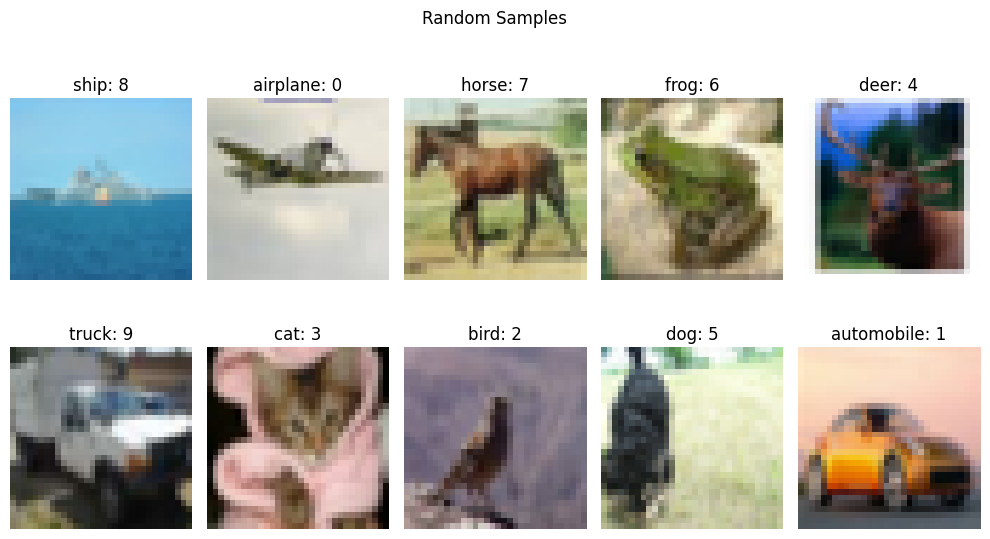

In [163]:
samples = {}

for image, label in train_subset:
    label = torch.argmax(label).item()

    if label not in samples:
        samples[f"{classes[label]}: {label}"] = image

    if len(samples) == len(classes):
        break

plot_images(list(samples.values()), list(samples.keys()), "Random Samples")

# Converting to Batchs


In [164]:
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=True)

# Training Model


In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device: {device.type}")

device: cuda


In [166]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=baseline_model.parameters())

In [167]:
start_time = time.time()
epochs = 30

train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log=True,
)

end_time = time.time()
print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 42.572, Train acc: 0.544, Val loss: 43.007, Val acc: 0.534
Epoch 20/30, Train loss: 36.943, Train acc: 0.605, Val loss: 38.743, Val acc: 0.579
Epoch 30/30, Train loss: 33.559, Train acc: 0.643, Val loss: 36.294, Val acc: 0.607
time: 596.82 seconds


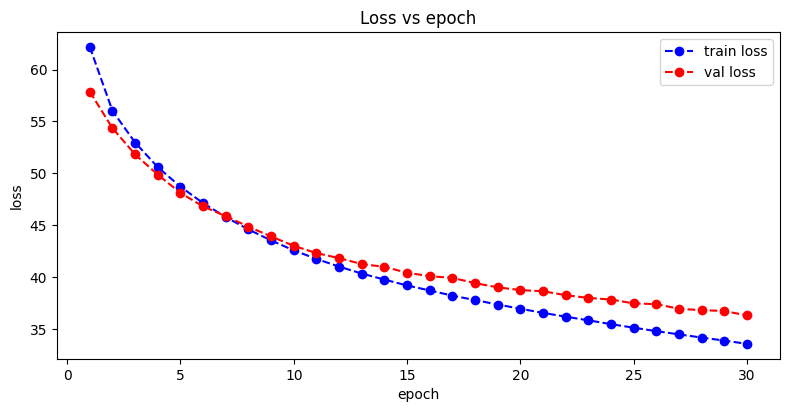

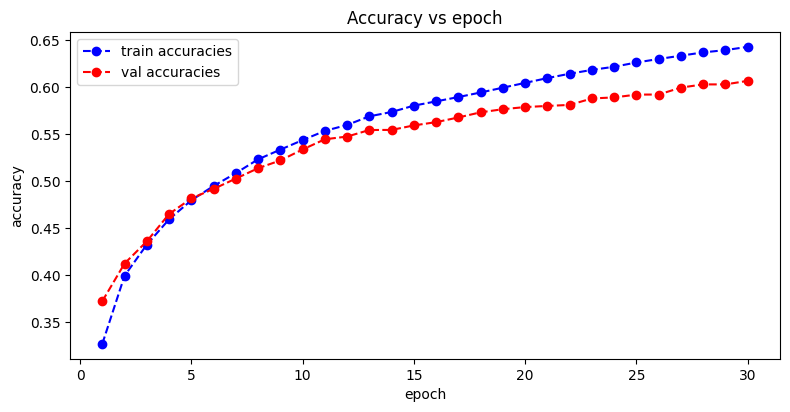

In [168]:
plot_loss(train_losses, validation_losses, epochs=epochs)
plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [169]:
save_model(baseline_model, "./baseline.pth")

model saved to ./baseline successfully!


# Model Imporvement


In [170]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()

        # 3 * 32 * 32 -> 64 * 30 * 30
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        # 64 * 15 * 15 -> 128 * 13 * 13
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        # 128 * 6 * 6 -> 256 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 2 * 2, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


improved_model = ImprovedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=improved_model.parameters())

In [171]:
start_time = time.time()
epochs = 30

train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=improved_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log=True,
)

end_time = time.time()
print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 55.678, Train acc: 0.373, Val loss: 55.29, Val acc: 0.371
Epoch 20/30, Train loss: 47.326, Train acc: 0.469, Val loss: 47.194, Val acc: 0.469
Epoch 30/30, Train loss: 42.599, Train acc: 0.528, Val loss: 42.565, Val acc: 0.526
time: 719.21 seconds


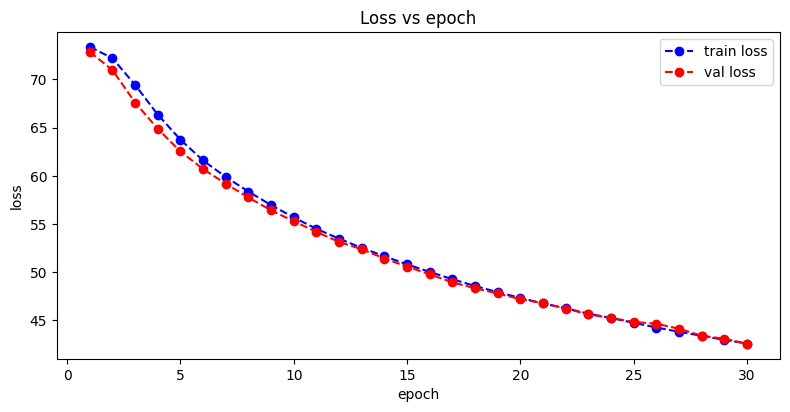

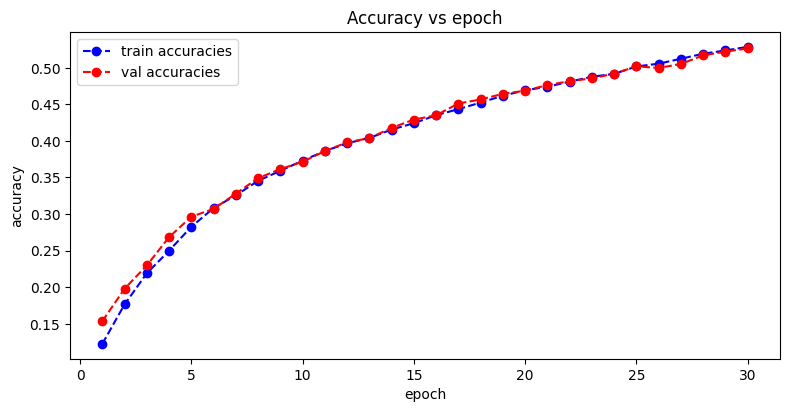

In [172]:
plot_loss(train_losses, validation_losses, epochs=epochs)
plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [173]:
save_model(improved_model, "./improvedmodel.pth")

model saved to ./improvedmodel successfully!


# Adding Batch Normalization


In [174]:
class BnModel(nn.Module):
    def __init__(self):
        super(BnModel, self).__init__()

        self.relu = nn.ReLU()
        # 3 * 32 * 32 -> 64 * 28 * 28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        # 64 * 14 * 14 -> 64 * 12 * 12
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        # 64 * 6 * 6 -> 63 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.averagepool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)
        self.fc2 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)
        self.fc3 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.averagepool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


bn_model = BnModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=bn_model.parameters())

In [175]:
start_time = time.time()
epochs = 30

train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=bn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log=True,
)

end_time = time.time()
print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 30.549, Train acc: 0.666, Val loss: 30.621, Val acc: 0.662
Epoch 20/30, Train loss: 22.266, Train acc: 0.757, Val loss: 26.55, Val acc: 0.712
Epoch 30/30, Train loss: 17.292, Train acc: 0.812, Val loss: 24.364, Val acc: 0.739
time: 739.08 seconds


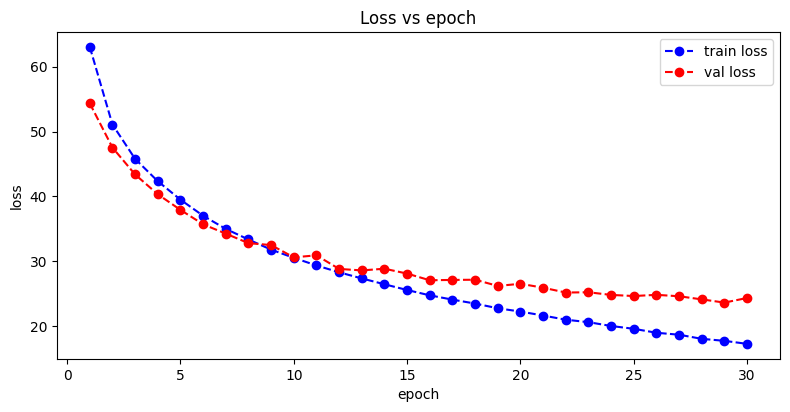

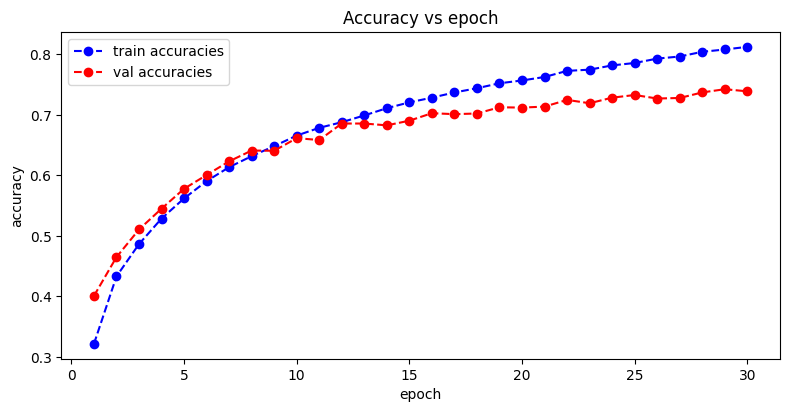

In [176]:
plot_loss(train_losses, validation_losses, epochs=epochs)
plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [177]:
save_model(bn_model, "./bnmodel.pth")

model saved to ./bnmodel successfully!


# Adding Dropout


In [178]:
class DoModel(nn.Module):
    def __init__(self):
        super(DoModel, self).__init__()

        self.relu = nn.ReLU()
        # 3 * 32 * 32 -> 64 * 28 * 28
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        # 64 * 14 * 14 -> 64 * 14 * 14
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        # 64 * 6 * 6 -> 63 * 4 * 4
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.averagepool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)
        self.fc2 = nn.Linear(64 * 4 * 4, 64 * 4 * 4)
        self.fc3 = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.averagepool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


do_model = DoModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=do_model.parameters())

In [179]:
start_time = time.time()
epochs = 30

train_losses, train_accuracies, validation_losses, validation_accuracies = train(
    model=do_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    log=True,
)

end_time = time.time()
print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 10/30, Train loss: 30.629, Train acc: 0.664, Val loss: 32.175, Val acc: 0.642
Epoch 20/30, Train loss: 22.22, Train acc: 0.758, Val loss: 26.853, Val acc: 0.704
Epoch 30/30, Train loss: 17.423, Train acc: 0.81, Val loss: 24.755, Val acc: 0.735
time: 736.72 seconds


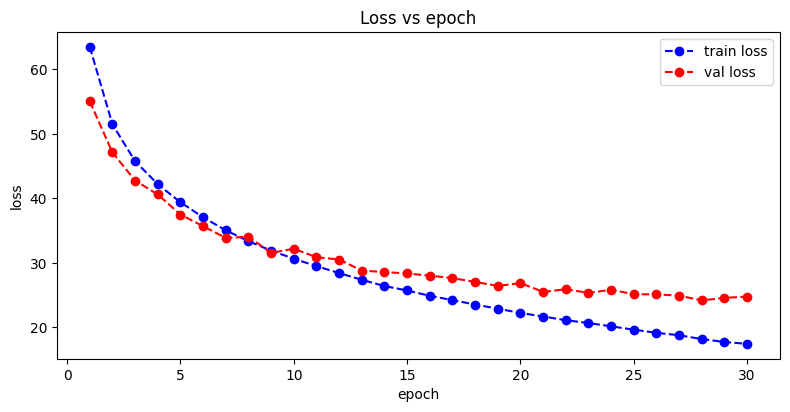

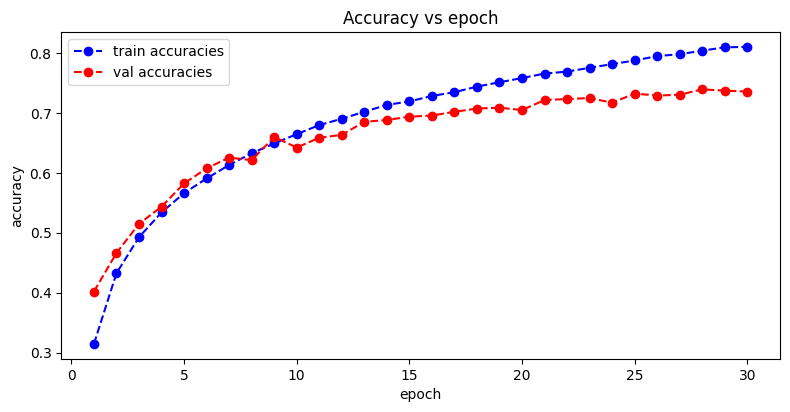

In [180]:
plot_loss(train_losses, validation_losses, epochs=epochs)
plot_acc(train_accuracies, validation_accuracies, epochs=epochs)

In [181]:
save_model(bn_model, "./domodel.pth")

model saved to ./domodel successfully!


# Test and Confusion Matrix


baseline model:
loss= 36.084, accuracy= 0.609


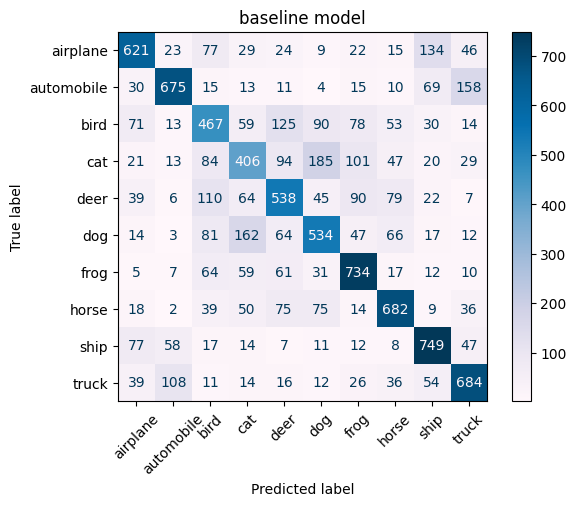

improved model:
loss= 42.706, accuracy= 0.524


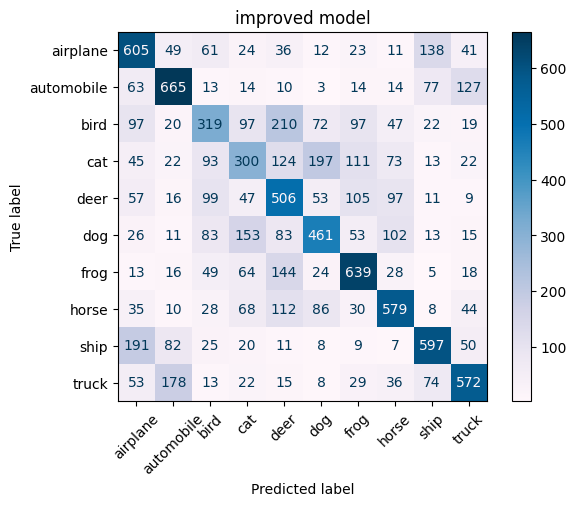

batch normalization model
loss= 24.377, accuracy= 0.735


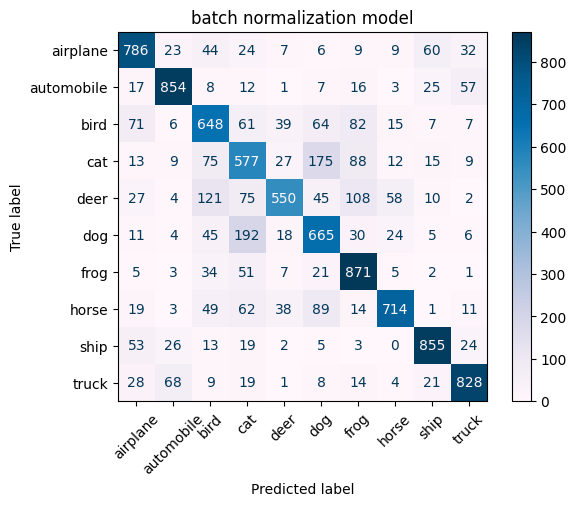

dropout model
loss= 24.3, accuracy= 0.742


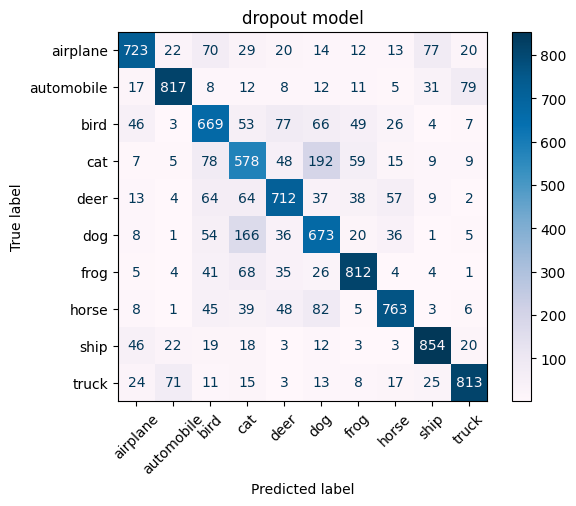

In [182]:
base_loss, base_accuracy, base_preds, base_labels = test(
    model=baseline_model, test_loader=test_loader, criterion=criterion, device=device
)
print("baseline model:")
print(f"loss= {np.round(base_loss, 3)}, accuracy= {np.round(base_accuracy, 3)}")
plot_confusion_matrix(
    base_labels, base_preds, class_names=classes, title="baseline model"
)


improved_loss, improved_accuracy, improved_preds, improved_labels = test(
    model=improved_model, test_loader=test_loader, criterion=criterion, device=device
)
print("improved model:")
print(f"loss= {np.round(improved_loss, 3)}, accuracy= {np.round(improved_accuracy, 3)}")
plot_confusion_matrix(
    improved_labels, improved_preds, class_names=classes, title="improved model"
)


bn_loss, bn_accuracy, bn_preds, bn_labels = test(
    model=bn_model, test_loader=test_loader, criterion=criterion, device=device
)
print("batch normalization model")
print(f"loss= {np.round(bn_loss, 3)}, accuracy= {np.round(bn_accuracy, 3)}")
plot_confusion_matrix(
    bn_labels, bn_preds, class_names=classes, title="batch normalization model"
)


do_loss, do_accuracy, do_preds, do_labels = test(
    model=do_model, test_loader=test_loader, criterion=criterion, device=device
)
print("dropout model")
print(f"loss= {np.round(do_loss, 3)}, accuracy= {np.round(do_accuracy, 3)}")
plot_confusion_matrix(do_labels, do_preds, class_names=classes, title="dropout model")